In [1]:
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
from matplotlib import pyplot as plt
import shutil
from tqdm import tqdm
import torch
import torchvision
import time
import copy
from torchvision import transforms, models

In [15]:
class RemoveBackgroundAndCrop:
    def __init__(self, img):
        self.img = img
        self.mask = img.copy()
        self.x00, self.y00, self.r00 = 0, 0, 0

    def crop(self, save_path):
        crop_radius = 1.42 * self.r00 / 2
        x0, y0 = int(self.x00), int(self.y00)
        cropped_img = self.img[y0 - int(crop_radius): y0 + int(crop_radius), x0 - int(crop_radius): x0 + int(crop_radius)]

        h, w = cropped_img.shape[:2]
        cv2.imwrite(save_path, cropped_img)

        # Save cropped image sections
        for i in range(5, min(h, w) // 3, 5):
            crop_img = cropped_img[i:h - i, i:w - i]
            cv2.imwrite(f"{save_path[:-4]}_Crop_{i}.jpg", crop_img)

        # Divide into four quadrants and save each
        quadrants = [
            (0, h // 2, 0, w // 2),  # Top-left
            (h // 2, h, w // 2, w),  # Bottom-right
            (h // 2, h, 0, w // 2),  # Bottom-left
            (0, h // 2, w // 2, w)   # Top-right
        ]
        for idx, (y1, y2, x1, x2) in enumerate(quadrants, 1):
            quadrant_img = cropped_img[y1:y2, x1:x2]
            cv2.imwrite(f"{save_path[:-4]}_image{idx}.jpg", quadrant_img)

    def crop_test(self, save_path):
        self.crop(save_path)
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(save_path, self.img)

    def find_circle(self):
        img = cv2.convertScaleAbs(self.img, alpha=1.2, beta=0)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        circles = cv2.HoughCircles(
            gray, cv2.HOUGH_GRADIENT, 1, 10,
            param1=10, param2=5, minRadius=40, maxRadius=250
        )
        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")
            for x, y, r in circles:
                if ((self.x00 - 15) < x < (self.x00 + 15)) and ((self.y00 - 15) < y < (self.y00 + 15)):
                    if r > self.r00:
                        self.x00, self.y00, self.r00 = x, y, r

        # Fallback if no circles found
        if self.r00 == 0:
            ret, thresh = cv2.threshold(self.mask, 235, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                (self.x00, self.y00), self.r00 = cv2.minEnclosingCircle(largest_contour)

    def find_coordinates(self):
        ret, thresh = cv2.threshold(self.mask, 235, 255, cv2.THRESH_BINARY)
        M = cv2.moments(thresh)
        self.x00, self.y00 = int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])

    def remove_background(self):
        main_rect_size, fg_size = 0.08, 0.01
        img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        mask = np.zeros((h, w), np.uint8)

        # Define background and foreground areas
        bg_rect = (int(w * main_rect_size), int(h * main_rect_size), w - int(w * main_rect_size), h - int(h * main_rect_size))
        fg_rect = (int(w * (1 - fg_size) / 2), int(h * (1 - fg_size) / 2), w - int(w * fg_size), h - int(h * fg_size))

        # Apply GrabCut with initial rectangle
        cv2.rectangle(mask, fg_rect[:2], fg_rect[2:], cv2.GC_FGD, -1)
        bgd_model, fgd_model = np.zeros((1, 65), np.float64), np.zeros((1, 65), np.float64)
        cv2.grabCut(img, mask, bg_rect, bgd_model, fgd_model, 3, cv2.GC_INIT_WITH_RECT)
        cv2.rectangle(mask, bg_rect[:2], bg_rect[2:], cv2.GC_PR_BGD, thickness=3)

        # Final mask result
        cv2.grabCut(img, mask, bg_rect, bgd_model, fgd_model, 10, cv2.GC_INIT_WITH_MASK)
        mask_result = np.where((mask == 1) | (mask == 3), 255, 0).astype('uint8')
        self.img = cv2.bitwise_and(img, img, mask=mask_result)
        self.img[mask_result == 0] = [255, 255, 255]
        self.mask = mask_result

def process_images(folder, count, is_test=False):
    for index in tqdm(range(count), desc=f"Processing {'test' if is_test else 'train'} images"):
        img_path = os.path.join(folder, f"{index:04}.jpg")
        img = cv2.imread(img_path)
        if img is not None:
            processor = RemoveBackgroundAndCrop(img)
            processor.remove_background()
            processor.find_coordinates()
            processor.find_circle()
            if is_test:
                processor.crop_test(img_path)
            else:
                processor.crop(img_path)
        else:
            print(f"Failed to read image at {img_path}")

# Process the images for different datasets
process_images('plates/train/dirty', 20)
process_images('plates/train/cleaned', 20)


Processing train images: 100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


In [16]:
process_images('plates/test', 744, is_test=True)

Processing test images: 100%|██████████| 744/744 [12:34<00:00,  1.01s/it]


In [17]:
data_root = "plates"

train_dir = 'train'
val_dir = 'val'
class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 271/271 [00:00<00:00, 286.67it/s]


In [18]:
train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.09, p=0.75, interpolation=3, fill=255),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset_transforms = {
                      'orig': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),

                      '140': transforms.Compose([
    transforms.CenterCrop(140),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     '135': transforms.Compose([
    transforms.CenterCrop(135),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '130': transforms.Compose([
    transforms.CenterCrop(130),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '125': transforms.Compose([
    transforms.CenterCrop(125),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '120': transforms.Compose([
    transforms.CenterCrop(120),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '115': transforms.Compose([
    transforms.CenterCrop(115),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '110': transforms.Compose([
    transforms.CenterCrop(110),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '105': transforms.Compose([
    transforms.CenterCrop(105),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '100': transforms.Compose([
    transforms.CenterCrop(100),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     '95': transforms.Compose([
    transforms.CenterCrop(95),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '90': transforms.Compose([
    transforms.CenterCrop(90),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '85': transforms.Compose([
    transforms.CenterCrop(85),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '80': transforms.Compose([
    transforms.CenterCrop(80),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '75': transforms.Compose([
    transforms.CenterCrop(75),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '70': transforms.Compose([
    transforms.CenterCrop(70),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     }

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

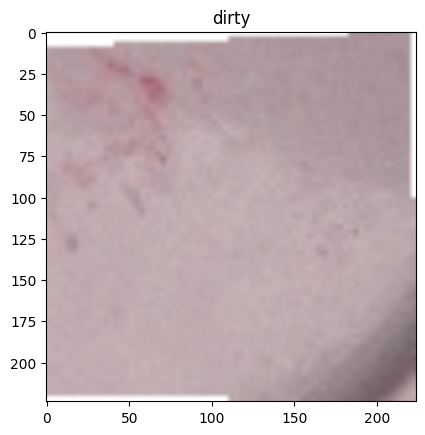

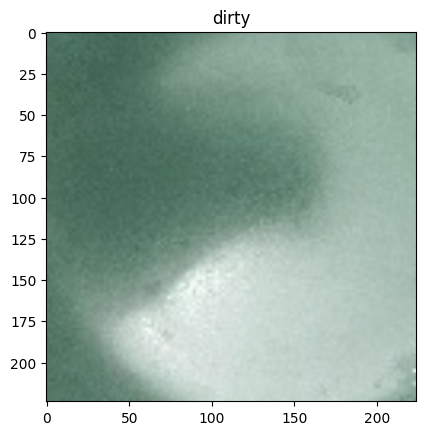

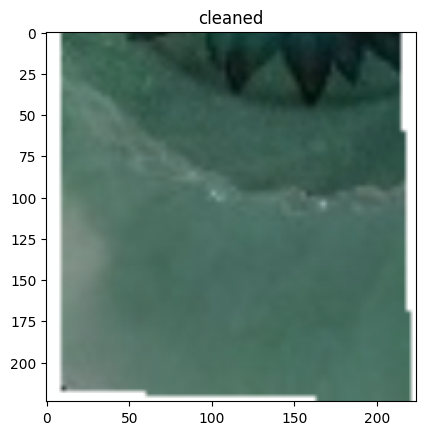

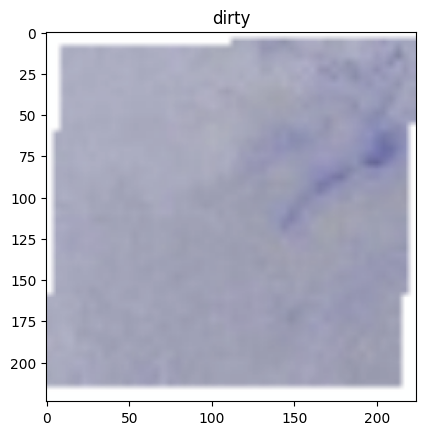

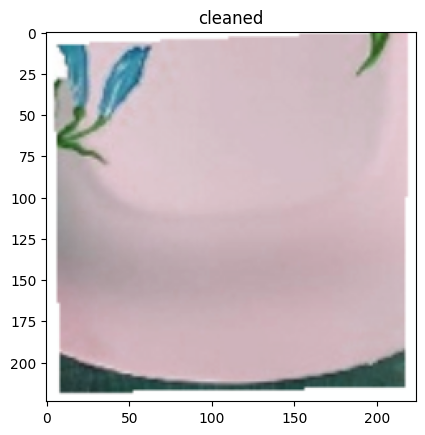

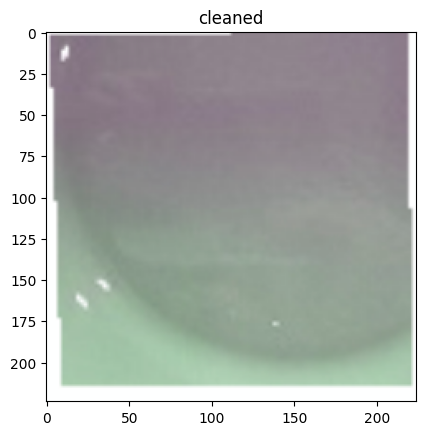

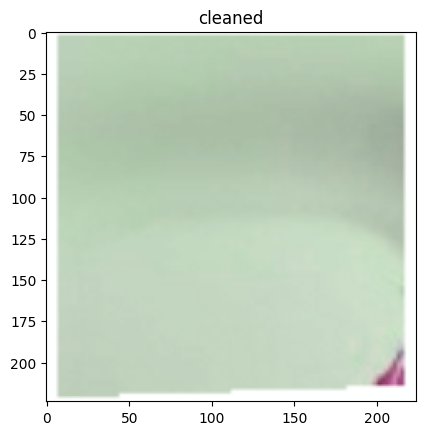

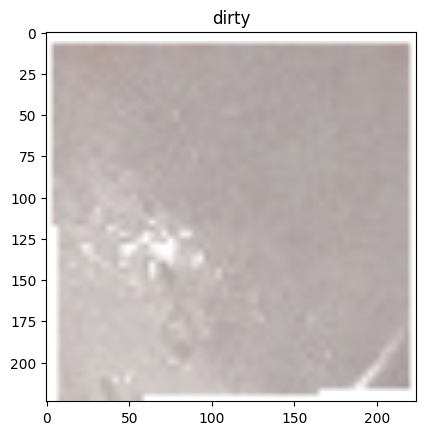

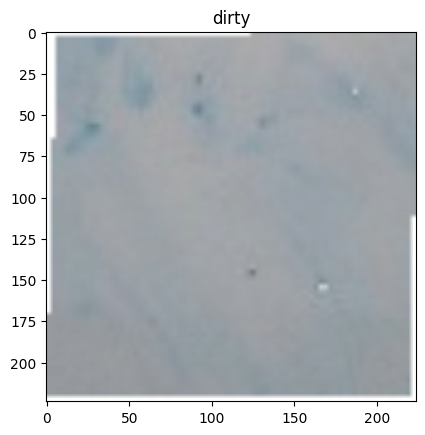

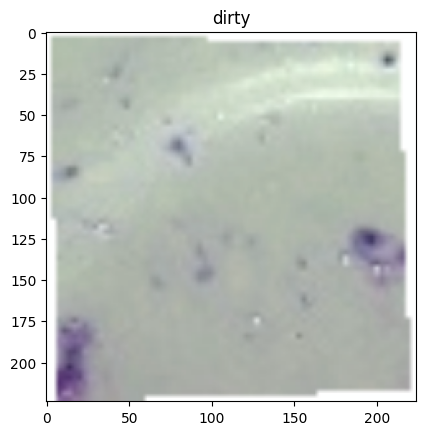

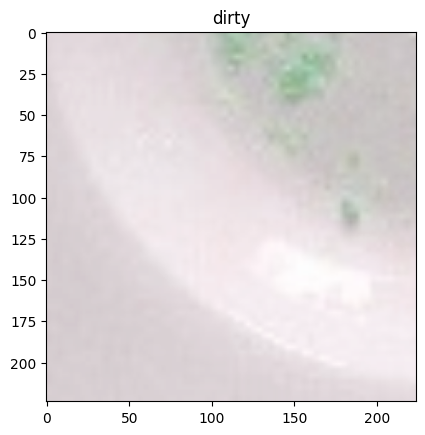

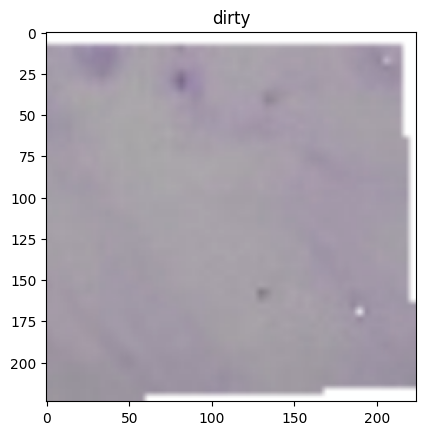

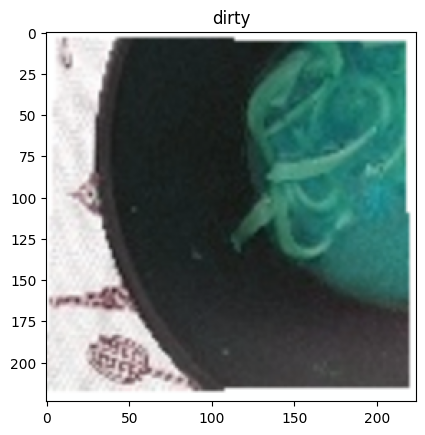

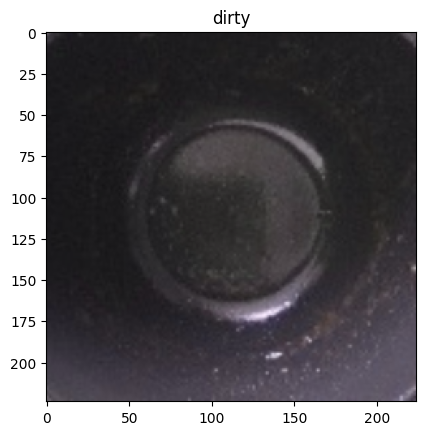

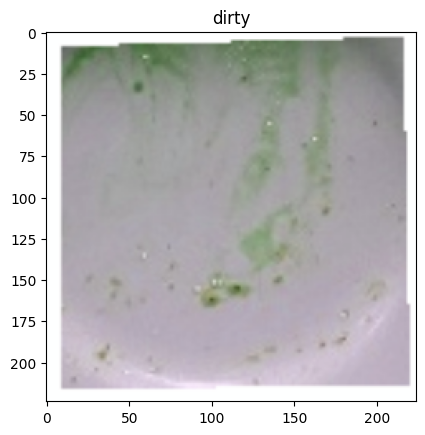

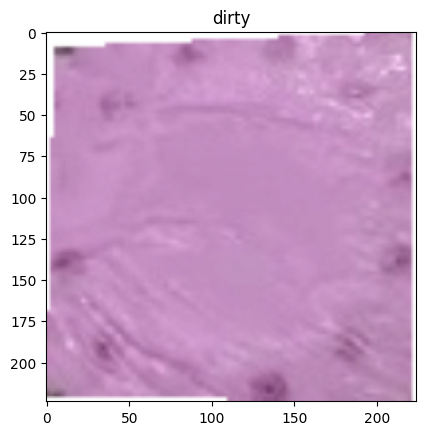

In [19]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.1)

X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, loss, optimizer, scheduler, num_epochs):

    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}

    for epoch in range(num_epochs):
        print("Epoch {}/{}:".format(epoch, num_epochs - 1), end="")
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()

            running_loss = 0.
            running_acc = 0.


            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()


                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print("{} Loss: {:.4f} Acc: {:.4f} ".format(phase, epoch_loss, epoch_acc), end="")

            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)

    return model, loss_hist, acc_hist

device

device(type='cuda')

In [22]:
model = models.resnet152(pretrained=True)
for param in model.parameters():
   param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [23]:
model, loss, acc = train_model(model, loss, optimizer, scheduler, num_epochs=30); #20 best

Epoch 0/29:

100%|██████████| 29/29 [00:07<00:00,  3.80it/s]


train Loss: 0.5530 Acc: 0.6940 

100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


val Loss: 0.4288 Acc: 0.7778 Epoch 1/29:

100%|██████████| 29/29 [00:07<00:00,  4.04it/s]


train Loss: 0.3998 Acc: 0.8405 

100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


val Loss: 0.4896 Acc: 0.7650 Epoch 2/29:

100%|██████████| 29/29 [00:07<00:00,  4.05it/s]


train Loss: 0.4674 Acc: 0.7478 

100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


val Loss: 0.3582 Acc: 0.8148 Epoch 3/29:

100%|██████████| 29/29 [00:07<00:00,  4.01it/s]


train Loss: 0.3484 Acc: 0.8599 

100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


val Loss: 0.3261 Acc: 0.8380 Epoch 4/29:

100%|██████████| 29/29 [00:07<00:00,  4.02it/s]


train Loss: 0.3597 Acc: 0.8556 

100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


val Loss: 0.2734 Acc: 0.8877 Epoch 5/29:

100%|██████████| 29/29 [00:07<00:00,  3.98it/s]


train Loss: 0.2980 Acc: 0.8685 

100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


val Loss: 0.5257 Acc: 0.7361 Epoch 6/29:

100%|██████████| 29/29 [00:07<00:00,  4.04it/s]


train Loss: 0.4085 Acc: 0.8233 

100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


val Loss: 0.3056 Acc: 0.8773 Epoch 7/29:

100%|██████████| 29/29 [00:07<00:00,  4.02it/s]


train Loss: 0.3256 Acc: 0.8621 

100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


val Loss: 0.2816 Acc: 0.8773 Epoch 8/29:

100%|██████████| 29/29 [00:07<00:00,  4.02it/s]


train Loss: 0.2709 Acc: 0.9159 

100%|██████████| 6/6 [00:05<00:00,  1.00it/s]


val Loss: 0.3057 Acc: 0.8484 Epoch 9/29:

100%|██████████| 29/29 [00:07<00:00,  4.02it/s]


train Loss: 0.2901 Acc: 0.8772 

100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


val Loss: 0.2791 Acc: 0.8692 Epoch 10/29:

100%|██████████| 29/29 [00:07<00:00,  3.99it/s]


train Loss: 0.2923 Acc: 0.8728 

100%|██████████| 6/6 [00:05<00:00,  1.00it/s]


val Loss: 0.2617 Acc: 0.9086 Epoch 11/29:

100%|██████████| 29/29 [00:07<00:00,  4.04it/s]


train Loss: 0.2925 Acc: 0.8642 

100%|██████████| 6/6 [00:05<00:00,  1.00it/s]


val Loss: 0.2784 Acc: 0.9294 Epoch 12/29:

100%|██████████| 29/29 [00:07<00:00,  4.04it/s]


train Loss: 0.3060 Acc: 0.8750 

100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


val Loss: 0.2979 Acc: 0.8981 Epoch 13/29:

100%|██████████| 29/29 [00:07<00:00,  4.00it/s]


train Loss: 0.3418 Acc: 0.8513 

100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


val Loss: 0.2926 Acc: 0.9086 Epoch 14/29:

100%|██████████| 29/29 [00:07<00:00,  3.94it/s]


train Loss: 0.2611 Acc: 0.9052 

100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


val Loss: 0.2546 Acc: 0.9294 Epoch 15/29:

100%|██████████| 29/29 [00:07<00:00,  3.93it/s]


train Loss: 0.2795 Acc: 0.8922 

100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


val Loss: 0.2267 Acc: 0.9109 Epoch 16/29:

100%|██████████| 29/29 [00:07<00:00,  4.02it/s]


train Loss: 0.2595 Acc: 0.8879 

100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


val Loss: 0.2516 Acc: 0.8773 Epoch 17/29:

100%|██████████| 29/29 [00:06<00:00,  4.14it/s]


train Loss: 0.2850 Acc: 0.8772 

100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


val Loss: 0.2518 Acc: 0.9190 Epoch 18/29:

100%|██████████| 29/29 [00:07<00:00,  4.09it/s]


train Loss: 0.2803 Acc: 0.8815 

100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


val Loss: 0.2713 Acc: 0.8773 Epoch 19/29:

100%|██████████| 29/29 [00:07<00:00,  4.10it/s]


train Loss: 0.2932 Acc: 0.8685 

100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


val Loss: 0.2110 Acc: 0.9294 Epoch 20/29:

100%|██████████| 29/29 [00:07<00:00,  4.07it/s]


train Loss: 0.2772 Acc: 0.8685 

100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


val Loss: 0.2269 Acc: 0.9190 Epoch 21/29:

100%|██████████| 29/29 [00:07<00:00,  4.11it/s]


train Loss: 0.3116 Acc: 0.8556 

100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


val Loss: 0.2524 Acc: 0.9086 Epoch 22/29:

100%|██████████| 29/29 [00:07<00:00,  4.10it/s]


train Loss: 0.2925 Acc: 0.8815 

100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


val Loss: 0.2716 Acc: 0.8981 Epoch 23/29:

100%|██████████| 29/29 [00:07<00:00,  3.88it/s]


train Loss: 0.3073 Acc: 0.8685 

100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


val Loss: 0.2626 Acc: 0.8981 Epoch 24/29:

100%|██████████| 29/29 [00:07<00:00,  4.07it/s]


train Loss: 0.2943 Acc: 0.8750 

100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


val Loss: 0.2791 Acc: 0.9190 Epoch 25/29:

100%|██████████| 29/29 [00:07<00:00,  4.08it/s]


train Loss: 0.2748 Acc: 0.8858 

100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


val Loss: 0.2669 Acc: 0.8900 Epoch 26/29:

100%|██████████| 29/29 [00:07<00:00,  4.11it/s]


train Loss: 0.2526 Acc: 0.8966 

100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


val Loss: 0.2658 Acc: 0.9086 Epoch 27/29:

100%|██████████| 29/29 [00:07<00:00,  4.05it/s]


train Loss: 0.2984 Acc: 0.8578 

100%|██████████| 6/6 [00:05<00:00,  1.00it/s]


val Loss: 0.2709 Acc: 0.8877 Epoch 28/29:

100%|██████████| 29/29 [00:07<00:00,  4.08it/s]


train Loss: 0.3233 Acc: 0.8599 

100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


val Loss: 0.2943 Acc: 0.8773 Epoch 29/29:

100%|██████████| 29/29 [00:07<00:00,  4.14it/s]


train Loss: 0.2948 Acc: 0.8685 

100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

val Loss: 0.2538 Acc: 0.9294 

In [24]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test\\unknown'

In [25]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

df = pd.DataFrame
for (i,tranforms) in dataset_transforms.items():
    test_dataset = ImageFolderWithPaths('plates/test', tranforms)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    model.eval()
    test_predictions = []
    test_img_paths = []
    for inputs, labels, paths in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
        test_predictions.append(
            torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
        test_img_paths.extend(paths)
    test_predictions = np.concatenate(test_predictions)


    submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
    submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
    submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
    submission_df.set_index('id', inplace=True)

    try : df = df.merge(submission_df, how='inner', on='id')
    except BaseException:
        df = submission_df
df.head(8)

FileNotFoundError: Couldn't find any class folder in plates/test.